<a href="https://colab.research.google.com/github/Louizaait/Seasonal-Quantile-Forecasting-of-Solar-Photovoltaic-Power-using-Q-CNN-GRU-/blob/main/Q_CNN_GRU(Australia).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
pip install pysolar pvlib properscoring

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import io
import os
import plotly.graph_objects as go
import joblib

from sklearn.preprocessing import MinMaxScaler

from tensorflow import keras
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Sequential, load_model
from keras.layers import GRU, Dense, Flatten, LSTM, Conv1D, MaxPooling1D,Input

from pysolar.solar import get_altitude, get_azimuth
from pvlib.location import Location
from pvlib.solarposition import get_solarposition
import pytz
import pvlib

from tensorflow_probability import distributions as tfd
from tensorflow_probability import layers as tfpl
import tensorflow as tf
from tensorflow.keras import backend as K
import properscoring as ps
from scipy import stats


In [3]:
from google.colab import files
files.upload()


Saving 91-Site_DKA-M9_B-Phase.csv to 91-Site_DKA-M9_B-Phase.csv


Data preprocessing


In [4]:
import pandas as pd

# Load and preprocess data
df = pd.read_csv('91-Site_DKA-M9_B-Phase.csv')[['timestamp', 'Active_Power']]

# Convert 'timestamp' column to datetime format
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Set 'timestamp' as the index for time series analysis
df.set_index('timestamp', inplace=True)

# Resample data to 1-hour intervals and calculate the mean for each period
df_resampled = df.resample('1h').mean()

# Get month from the index to determine if it's summer or winter
df_resampled['month'] = df_resampled.index.month

# Assume:
# Summer: Dec-Feb (months 12-2), Sunrise at 5:30 AM, Sunset at 7:30 PM
# Winter: Jun-Aug (months 6-8), Sunrise at 7:00 AM, Sunset at 5:30 PM
df_resampled['time_range'] = df_resampled['month'].apply(lambda x: ('05:30', '19:30') if x in [12, 1, 2] else ('07:00', '17:30'))

# Filter data based on the sunrise and sunset times
df_filtered = pd.DataFrame()

for start_time, end_time in df_resampled['time_range'].unique():
    df_filtered = pd.concat([df_filtered, df_resampled.between_time(start_time, end_time)])

# Fill missing values with the corresponding values from the previous year
df_filtered['Active_Power'] = df_filtered['Active_Power'].fillna(df_filtered['Active_Power'].shift(-360))
df_filtered['Active_Power'] = df_filtered['Active_Power'].fillna(df_filtered['Active_Power'].shift(360))

# Reset the index to make 'timestamp' a column again
df3 = df_filtered.reset_index()[['timestamp', 'Active_Power']] # Reset the index before selecting columns
df3.set_index('timestamp', inplace=True)


In [5]:
# Define split ranges for training, validation, and testing
train_start = "2022-01-01"
train_end = "2022-12-31"  # Train for 2022
val_start = "2023-01-01"
val_end = "2023-12-31"    # Validation for 2023
test_start = "2024-01-01"
test_end = "2024-12-31"   # Test for 2024

# Ensure DateTime column is datetime formatted
# df3['timestamp'] = pd.to_datetime(df3['timestamp']) # This line is causing the error, as 'timestamp' is now the index
df3.index = pd.to_datetime(df3.index) # Convert the index to datetime

# Data Splitting
# Use the index for splitting
train = df3[(df3.index >= train_start) & (df3.index <= train_end)].copy()
val = df3[(df3.index >= val_start) & (df3.index <= val_end)].copy()
test = df3[(df3.index >= test_start) & (df3.index <= test_end)].copy()


# Seasonal Splitting for Alice Springs (based on timestamp column)
spring = test.index.month.isin([9, 10, 11])  # Spring months (Sep-Nov)
summer = test.index.month.isin([12, 1, 2])  # Summer months (Dec-Feb)
autumn = test.index.month.isin([3, 4, 5])   # Autumn months (Mar-May)
winter = test.index.month.isin([6, 7, 8])   # Winter months (Jun-Aug)

# Now you can filter the data based on the seasons
spring_data = test[spring]
summer_data = test[summer]
autumn_data = test[autumn]


# Scaling
scaler = MinMaxScaler().fit(train[['Active_Power']])
joblib.dump(scaler, 'scaler.gz')

def scale_samples(data, scaler):
    data_scaled = data.copy()
    data_scaled['Active_Power'] = scaler.transform(data[['Active_Power']])
    return data_scaled

train = scale_samples(train, scaler)
val = scale_samples(val, scaler)
test = scale_samples(summer_data, scaler)

# Multi-step Data Preparation
def shift_samples_multi_step(data, lookback=48, steps_ahead=1):
    data_x, data_y = [], []
    power_values = data['Active_Power'].values

    for i in range(len(power_values) - lookback - steps_ahead):
        data_x.append(power_values[i:i + lookback].reshape(-1, 1))
        data_y.append(power_values[i + lookback:i + lookback + steps_ahead])
    return np.array(data_x), np.array(data_y)

steps_ahead = 1
x_train, y_train = shift_samples_multi_step(train, lookback=48, steps_ahead=steps_ahead)
x_val, y_val = shift_samples_multi_step(val, lookback=48, steps_ahead=steps_ahead)
x_test, y_test = shift_samples_multi_step(test, lookback=48, steps_ahead=steps_ahead)

# Define Pinball Loss
def single_quantile_loss(tau=0.5):
    def loss(y_true, y_pred):
        err = y_true - y_pred
        return K.mean(K.maximum(tau * err, (tau - 1) * err), axis=-1)
    return loss

quantiles = np.round(np.linspace(0.01, 0.99, 99), 2)

# Model Architecture
inputs = Input(shape=(x_train.shape[1], 1))
x = Conv1D(22, 4, activation='relu', padding='same')(inputs)
x = MaxPooling1D(1)(x)
x = Conv1D(22, 4, activation='relu', padding='same')(x)
x = GRU(31, dropout=0.1)(x)
x = Flatten()(x)
outputs = {f'quantile_{tau:.2f}': Dense(steps_ahead, name=f'quantile_{tau:.2f}')(x) for tau in quantiles}

model =keras.Model(inputs=inputs, outputs=outputs)
model.compile(
    loss={f'quantile_{tau:.2f}': single_quantile_loss(tau) for tau in quantiles},
    optimizer='adam'
)

# Training
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
history2 = model.fit(
    x_train,
    {f'quantile_{tau:.2f}': y_train for tau in quantiles},
    validation_data=(x_val, {f'quantile_{tau:.2f}': y_val for tau in quantiles}),
    epochs=30,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1,
    shuffle=False
)

# Prediction and Evaluation
pred_test = model.predict(x_test)
pred_test = {tau: scaler.inverse_transform(pred_test[f'quantile_{tau:.2f}']) for tau in quantiles}
y_test = scaler.inverse_transform(y_test)

y_pred_ensemble = np.dstack([pred_test[tau] for tau in quantiles])
crps_scores = [
    np.mean(ps.crps_ensemble(np.nan_to_num(y_test[:, step]), np.nan_to_num(y_pred_ensemble[:, step, :])))
    for step in range(steps_ahead)
]

crps_scores = np.array(crps_scores) /10.5  # Normalize CRPS
print("CRPS Scores for each step:", crps_scores)
print("Mean Normalized CRPS Score:", np.mean(crps_scores))


Epoch 1/30
283/283 ━━━━━━━━━━━━━━━━━━━━ 100s 156ms/step - loss: 14.2269 - quantile_0.01_loss: 0.0070 - quantile_0.02_loss: 0.0120 - quantile_0.03_loss: 0.0299 - quantile_0.04_loss: 0.0233 - quantile_0.05_loss: 0.0259 - quantile_0.06_loss: 0.0566 - quantile_0.07_loss: 0.0347 - quantile_0.08_loss: 0.0806 - quantile_0.09_loss: 0.0456 - quantile_0.10_loss: 0.0563 - quantile_0.11_loss: 0.0659 - quantile_0.12_loss: 0.0621 - quantile_0.13_loss: 0.0600 - quantile_0.14_loss: 0.0733 - quantile_0.15_loss: 0.0829 - quantile_0.16_loss: 0.0879 - quantile_0.17_loss: 0.0722 - quantile_0.18_loss: 0.0743 - quantile_0.19_loss: 0.0762 - quantile_0.20_loss: 0.0914 - quantile_0.21_loss: 0.0938 - quantile_0.22_loss: 0.1080 - quantile_0.23_loss: 0.0946 - quantile_0.24_loss: 0.0981 - quantile_0.25_loss: 0.0936 - quantile_0.26_loss: 0.1247 - quantile_0.27_loss: 0.1431 - quantile_0.28_loss: 0.1204 - quantile_0.29_loss: 0.1101 - quantile_0.30_loss: 0.1132 - quantile_0.31_loss: 0.1107 - quantile_0.32_loss: 0.1111 

Reliability diagram

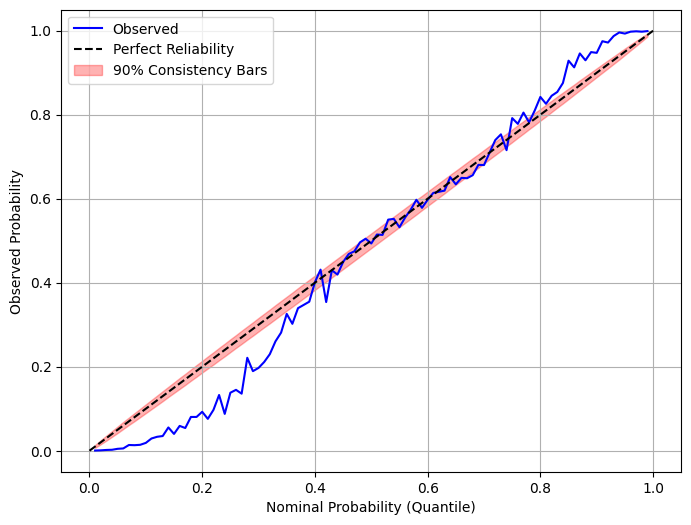

In [7]:
# Calculate the observed probabilities for each quantile
def compute_observed_probabilities(y_true, y_pred, quantiles):
    observed_probabilities = []
    for tau in quantiles:
        # For each quantile, compute the proportion of observed values <= the predicted value
        observed_prob = np.mean(y_true <= y_pred[tau], axis=0)
        observed_probabilities.append(observed_prob)
    return np.array(observed_probabilities)

# Function to compute consistency bars
def compute_consistency_bars(quantiles, n_samples, confidence_level=0.90):
    from scipy.stats import binom  # Import the binom function from scipy.stats
    lower_bounds = []
    upper_bounds = []
    alpha = 1 - confidence_level
    for q in quantiles:
        # Use binomial distribution to calculate bounds
        lower = binom.ppf(alpha / 2, n_samples, q) / n_samples
        upper = binom.ppf(1 - alpha / 2, n_samples, q) / n_samples
        lower_bounds.append(lower)
        upper_bounds.append(upper)
    return np.array(lower_bounds), np.array(upper_bounds)

# Example data (replace with your actual data)
n_samples = len(y_test)  # Number of samples in the test set

observed_probabilities = compute_observed_probabilities(y_test, pred_test, quantiles)

# Compute consistency bars
lower_bounds, upper_bounds = compute_consistency_bars(quantiles, n_samples)

# Plot reliability diagram with consistency bars
plt.figure(figsize=(8, 6))
plt.plot(quantiles, observed_probabilities, label='Observed', color='b')
plt.plot([0, 1], [0, 1], label='Perfect Reliability', linestyle='--', color='k')
plt.fill_between(quantiles, lower_bounds, upper_bounds, color='red', alpha=0.3, label='90% Consistency Bars')
plt.xlabel('Nominal Probability (Quantile)')
plt.ylabel('Observed Probability')

plt.legend()
plt.grid(True)
plt.show()